In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model
import tensorflow as tf

from sklearn.metrics import accuracy_score

ModuleNotFoundError: No module named 'keras'

In [2]:
from sklearn.model_selection import train_test_split
import cv2 as cv
import os

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [ ]:
X_train = []
y_train = []
cont = 0
for letra in os.listdir('/media/emanueloliveira/Dados/SCC0910ComputerVision/Dataset/train'):
    for image in load_images_from_folder(f'/media/emanueloliveira/Dados/SCC0910ComputerVision/Dataset/train/{letra}'):
        X_train.append(image)
        y_train.append(cont)
    cont += 1
  
X_test = []
y_test = []

cont = 0
for letra in os.listdir('/media/emanueloliveira/Dados/SCC0910ComputerVision/Dataset/test'):
    for image in load_images_from_folder(f'/media/emanueloliveira/Dados/SCC0910ComputerVision/Dataset/test/{letra}'):
        X_test.append(image)
        y_test.append(cont)
    cont += 1
    
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

### Testando com VGG

In [ ]:
import tensorflow.keras.applications as apps
from tensorflow import keras
from tensorflow.keras import layers

model = apps.VGG16(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
model = Model(inputs=model.input, outputs=model.get_layer(index=-1).output)
model.trainable = False

In [ ]:
print("Model output", model.output.shape)

Model output (None, 2, 2, 512)


In [ ]:
preds = model.predict(X_data[0:5])

1/1 [==============================] - 0s 121ms/step


In [ ]:
print("prediction shape", np.array(preds[0]).shape)

prediction shape (2, 2, 512)


In [ ]:
Predshape = np.array(preds[0]).reshape(-1).shape[0]

In [ ]:
# Extração de features
print("Feature extraction ...")
predictionTrain = np.array(model.predict(X_train))
featuresTrain = np.reshape(predictionTrain, (predictionTrain.shape[0], Predshape))
predictionTest = np.array(model.predict(X_test))
featuresTest = np.reshape(predictionTest, (predictionTest.shape[0], Predshape))

print('\tFeatures train shape: ', featuresData.shape)
print('\tFeatures test shape: ', featuresData.shape)

Feature extraction ...
1377/1377 [==============================] - 252s 183ms/step
	Features data shape:  (44062, 2048)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(featuresData)

print('X_reduced shape: ', X_reduced.shape)

X_reduced shape:  (44062, 154)


In [ ]:
from sklearn.preprocessing import label_binarize
labels = [i for i in range(0, 21)]

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_data, test_size=0.33)

y_train = np.array(label_binarize(y_train, classes=labels))
y_test = np.array(label_binarize(y_test, classes=labels))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [ ]:
print(f'training set shape {X_train.shape}')
print(f'testing set shape {X_test.shape}')
print(f'label train set shape {y_train.shape}')
print(f'label test set shape {y_test.shape}')

training set shape (22140, 154)
testing set shape (14541, 154)
label train set shape (22140, 21)
label test set shape (14541, 21)


In [ ]:
# Creating the Sequential Model
model = keras.Sequential([
    
    # Fully-connected layer
    layers.Dense(42, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(21, activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 42)                6510      
                                                                 
 dense_2 (Dense)             (None, 21)                903       
                                                                 
Total params: 7,413
Trainable params: 7,413
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
692/692 [==============================] - 2s 2ms/step - loss: 4.0253 - categorical_accuracy: 0.8436 - val_loss: 0.0652 - val_categorical_accuracy: 0.9862
Epoch 2/100
692/692 [==============================] - 1s 2ms/step - loss: 0.0300 - categorical_accuracy: 0.9938 - val_loss: 0.0275 - val_categorical_accuracy: 0.9949
Epoch 3/100
692/692 [==============================] - 1s 2ms/step - loss: 0.0089 - categorical_accuracy: 0.9975 - val_loss: 0.0236 - val_categorical_accuracy: 0.9954
Epoch 4/100
692/692 [==============================] - 1s 2ms/step - loss: 0.0027 - categorical_accuracy: 0.9993 - val_loss: 0.0160 - val_categorical_accuracy: 0.9969
Epoch 5/100
692/692 [==============================] - 1s 2ms/step - loss: 0.0121 - categorical_accuracy: 0.9978 - val_loss: 0.0455 - val_categorical_accuracy: 0.9944
Epoch 6/100
692/692 [==============================] - 1s 2ms/step - loss: 0.0312 - categorical_accuracy: 0.9949 - val_loss: 0.0514 - val_categorical_accuracy: 0.992

Best Validation Loss: 0.0153
Best Validation Accuracy: 0.9988


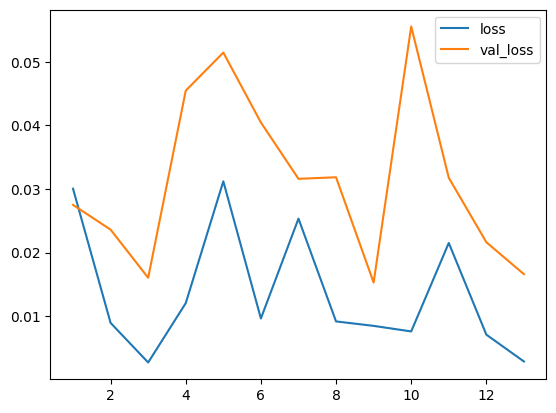

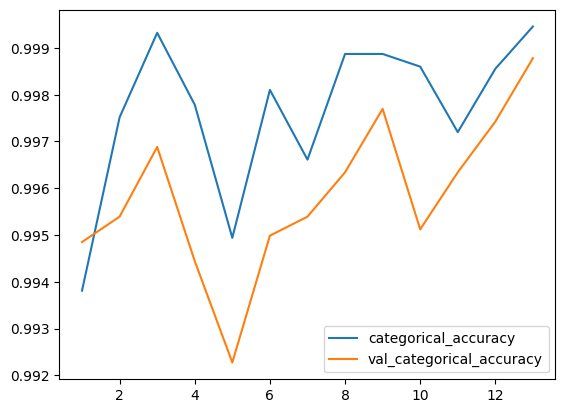

In [ ]:
# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()))

In [ ]:
# Decoding predições e labels de test por hard voting 
argy_test = [np.argmax(i) for i in y_test]
argy_pred = [np.argmax(i) for i in model.predict(X_test)]

455/455 [==============================] - 0s 742us/step


In [ ]:
# Resultado nos dados de test

print(f'VGG score on test set: {accuracy_score(argy_test, argy_pred)}')

VGG score on test set: 0.9967677601265388


### Testando com ResNet

In [ ]:
import tensorflow.keras.applications as apps
from tensorflow import keras
from tensorflow.keras import layers

model = apps.ResNet50(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
model = Model(inputs=model.input, outputs=model.get_layer(index=-1).output)
model.trainable = False

In [ ]:
print("Model output", model.output.shape)

Model output (None, 2, 2, 2048)


In [ ]:
preds = model.predict(X_data[0:5])

1/1 [==============================] - 1s 586ms/step


In [ ]:
print("prediction shape", np.array(preds[0]).shape)

prediction shape (2, 2, 2048)


In [ ]:
Predshape = np.array(preds[0]).reshape(-1).shape[0]
print(f"predshape: {Predshape}")

predshape: 8192


In [ ]:
# Extração de features
print("Feature extraction ...")
prediction = np.array(model.predict(X_data))
featuresData = np.reshape(prediction, (prediction.shape[0], Predshape))

print('\tFeatures data shape: ', featuresData.shape)

Feature extraction ...
1377/1377 [==============================] - 121s 88ms/step
	Features data shape:  (44062, 8192)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(featuresData)

print('X_reduced shape: ', X_reduced.shape)

X_reduced shape:  (44062, 380)


In [ ]:
from sklearn.preprocessing import label_binarize
labels = [i for i in range(0, 21)]

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_data, test_size=0.33)

y_train = np.array(label_binarize(y_train, classes=labels))
y_test = np.array(label_binarize(y_test, classes=labels))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [ ]:
print(f'training set shape {X_train.shape}')
print(f'testing set shape {X_test.shape}')
print(f'label train set shape {y_train.shape}')
print(f'label test set shape {y_test.shape}')

training set shape (22140, 380)
testing set shape (14541, 380)
label train set shape (22140, 21)
label test set shape (14541, 21)


In [ ]:
# Creating the Sequential Model
model = keras.Sequential([
    
    # Fully-connected layer
    layers.Dense(42, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(21, activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 42)                16002     
                                                                 
 dense_4 (Dense)             (None, 21)                903       
                                                                 
Total params: 16,905
Trainable params: 16,905
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
692/692 [==============================] - 1s 1ms/step - loss: 0.6845 - categorical_accuracy: 0.8841 - val_loss: 0.0310 - val_categorical_accuracy: 0.9930
Epoch 2/100
692/692 [==============================] - 1s 2ms/step - loss: 0.0138 - categorical_accuracy: 0.9977 - val_loss: 0.0115 - val_categorical_accuracy: 0.9984
Epoch 3/100
692/692 [==============================] - 1s 2ms/step - loss: 0.0045 - categorical_accuracy: 0.9995 - val_loss: 0.0051 - val_categorical_accuracy: 0.9995
Epoch 4/100
692/692 [==============================] - 1s 2ms/step - loss: 0.0020 - categorical_accuracy: 0.9999 - val_loss: 0.0035 - val_categorical_accuracy: 0.9996
Epoch 5/100
692/692 [==============================] - 1s 2ms/step - loss: 9.4987e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0029 - val_categorical_accuracy: 0.9996
Epoch 6/100
692/692 [==============================] - 1s 2ms/step - loss: 5.8702e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0022 - val_categorical_accurac

Best Validation Loss: 0.0012
Best Validation Accuracy: 0.9997


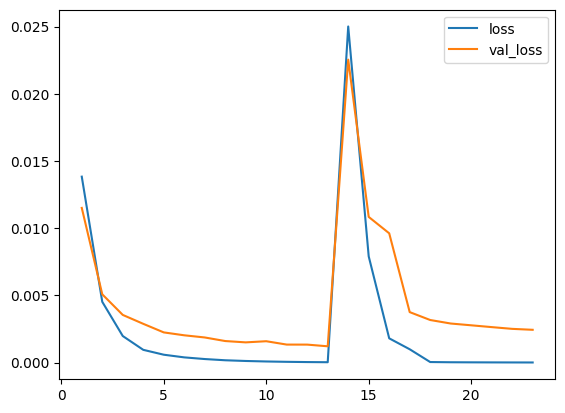

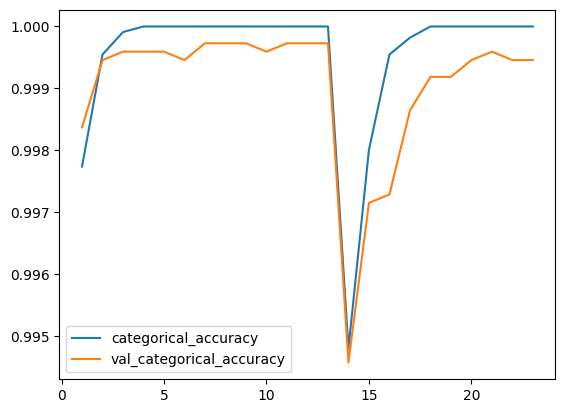

In [ ]:
# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()))

In [ ]:
# Decoding predições e labels de test por hard voting 
argy_test = [np.argmax(i) for i in y_test]
argy_pred = [np.argmax(i) for i in model.predict(X_test)]

455/455 [==============================] - 0s 659us/step


In [ ]:
# Resultado nos dados de test

print(f'ResNet score on test set: {accuracy_score(argy_test, argy_pred)}')

ResNet score on test set: 0.9993810604497627


### Testando com EfficientNetB3

In [ ]:
import tensorflow.keras.applications as apps
from tensorflow import keras
from tensorflow.keras import layers

model = apps.EfficientNetB3(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
model = Model(inputs=model.input, outputs=model.get_layer(index=-1).output)
model.trainable = False

In [ ]:
print("Model output", model.output.shape)

Model output (None, 2, 2, 1536)


In [ ]:
preds = model.predict(X_data[0:5])

1/1 [==============================] - 2s 2s/step


In [ ]:
print("prediction shape", np.array(preds[0]).shape)

prediction shape (2, 2, 1536)


In [ ]:
Predshape = np.array(preds[0]).reshape(-1).shape[0]

In [ ]:
# Extração de features
print("Feature extraction ...")
prediction = np.array(model.predict(X_data))
featuresData = np.reshape(prediction, (prediction.shape[0], Predshape))

Feature extraction ...
1377/1377 [==============================] - 114s 83ms/step


In [ ]:
print('\tFeatures data shape: ', featuresData.shape)

	Features data shape:  (44062, 6144)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(featuresData)

In [ ]:
print('X_reduced shape: ', X_reduced.shape)

X_reduced shape:  (44062, 208)


In [ ]:
from sklearn.preprocessing import label_binarize
labels = [i for i in range(0, 21)]

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_data, test_size=0.33)

y_train = np.array(label_binarize(y_train, classes=labels))
y_test = np.array(label_binarize(y_test, classes=labels))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [ ]:
print(f'training set shape {X_train.shape}')
print(f'testing set shape {X_test.shape}')
print(f'label train set shape {y_train.shape}')
print(f'label test set shape {y_test.shape}')

training set shape (22140, 208)
testing set shape (14541, 208)
label train set shape (22140, 21)
label test set shape (14541, 21)


In [ ]:
# Creating the Sequential Model
model = keras.Sequential([
    
    # Fully-connected layer
    layers.Dense(42, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(21, activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 42)                8778      
                                                                 
 dense_6 (Dense)             (None, 21)                903       
                                                                 
Total params: 9,681
Trainable params: 9,681
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
692/692 [==============================] - 1s 1ms/step - loss: 0.5230 - categorical_accuracy: 0.8839 - val_loss: 0.0606 - val_categorical_accuracy: 0.9932
Epoch 2/100
692/692 [==============================] - 1s 1ms/step - loss: 0.0343 - categorical_accuracy: 0.9966 - val_loss: 0.0196 - val_categorical_accuracy: 0.9982
Epoch 3/100
692/692 [==============================] - 1s 1ms/step - loss: 0.0133 - categorical_accuracy: 0.9986 - val_loss: 0.0105 - val_categorical_accuracy: 0.9992
Epoch 4/100
692/692 [==============================] - 1s 1ms/step - loss: 0.0066 - categorical_accuracy: 0.9995 - val_loss: 0.0065 - val_categorical_accuracy: 0.9995
Epoch 5/100
692/692 [==============================] - 1s 2ms/step - loss: 0.0036 - categorical_accuracy: 1.0000 - val_loss: 0.0044 - val_categorical_accuracy: 0.9996
Epoch 6/100
692/692 [==============================] - 1s 2ms/step - loss: 0.0022 - categorical_accuracy: 1.0000 - val_loss: 0.0031 - val_categorical_accuracy: 0.999

Best Validation Loss: 0.0004
Best Validation Accuracy: 0.9999


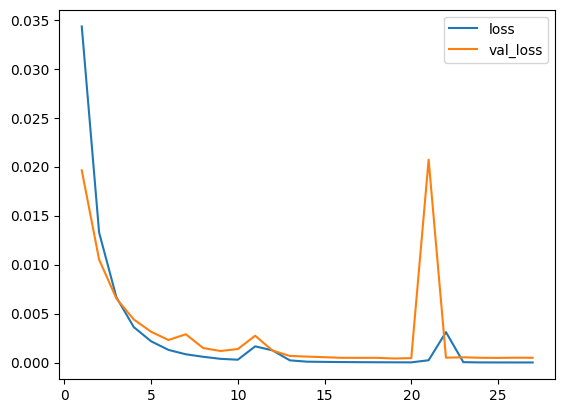

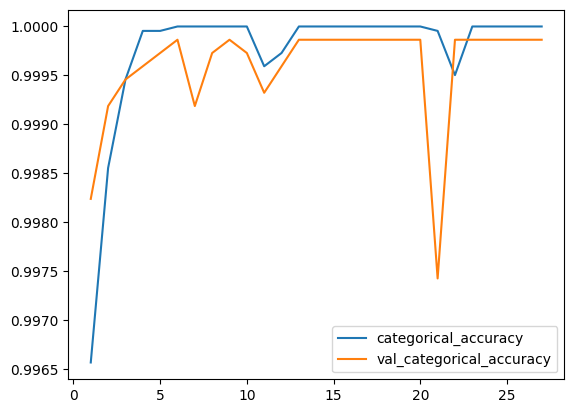

In [ ]:
# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()))

In [ ]:
# Decoding predições e labels de test por hard voting 
argy_test = [np.argmax(i) for i in y_test]
argy_pred = [np.argmax(i) for i in model.predict(X_test)]

455/455 [==============================] - 0s 714us/step


In [ ]:
# Resultado nos dados de test

print(f'EfficentNetB3 score on test set: {accuracy_score(argy_test, argy_pred)}')

EfficentNetB3 score on test set: 0.9995873736331752


### Testando com MobileNet

In [ ]:
import tensorflow.keras.applications as apps
from tensorflow import keras
from tensorflow.keras import layers

model = apps.MobileNetV2(input_shape=(64, 64, 3), include_top=False, weights='imagenet')
model = Model(inputs=model.input, outputs=model.get_layer(index=-1).output)
model.trainable = False

In [ ]:
print("Model output", model.output.shape)

Model output (None, 2, 2, 1280)


In [ ]:
preds = model.predict(X_data[0:5])

1/1 [==============================] - 0s 475ms/step


In [ ]:
print("prediction shape", np.array(preds[0]).shape)

prediction shape (2, 2, 1280)


In [ ]:
Predshape = np.array(preds[0]).reshape(-1).shape[0]
print(f"predshape: {Predshape}")

predshape: 5120


In [ ]:
# Extração de features
print("Feature extraction ...")
prediction = np.array(model.predict(X_data))
featuresData = np.reshape(prediction, (prediction.shape[0], Predshape))

print('\tFeatures data shape: ', featuresData.shape)

Feature extraction ...
1377/1377 [==============================] - 30s 22ms/step
	Features data shape:  (44062, 5120)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(featuresData)

print('X_reduced shape: ', X_reduced.shape)

X_reduced shape:  (44062, 243)


In [ ]:
from sklearn.preprocessing import label_binarize
labels = [i for i in range(0, 21)]

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_data, test_size=0.33)

y_train = np.array(label_binarize(y_train, classes=labels))
y_test = np.array(label_binarize(y_test, classes=labels))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [ ]:
print(f'training set shape {X_train.shape}')
print(f'testing set shape {X_test.shape}')
print(f'label train set shape {y_train.shape}')
print(f'label test set shape {y_test.shape}')

training set shape (22140, 243)
testing set shape (14541, 243)
label train set shape (22140, 21)
label test set shape (14541, 21)


In [ ]:
# Creating the Sequential Model
model = keras.Sequential([
    
    # Fully-connected layer
    layers.Dense(42, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(21, activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 42)                10248     
                                                                 
 dense_8 (Dense)             (None, 21)                903       
                                                                 
Total params: 11,151
Trainable params: 11,151
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
692/692 [==============================] - 1s 1ms/step - loss: 1.7281 - categorical_accuracy: 0.5024 - val_loss: 1.0013 - val_categorical_accuracy: 0.6889
Epoch 2/100
692/692 [==============================] - 1s 2ms/step - loss: 0.8023 - categorical_accuracy: 0.7533 - val_loss: 0.7438 - val_categorical_accuracy: 0.7647
Epoch 3/100
692/692 [==============================] - 1s 1ms/step - loss: 0.6073 - categorical_accuracy: 0.8091 - val_loss: 0.6454 - val_categorical_accuracy: 0.7938
Epoch 4/100
692/692 [==============================] - 1s 2ms/step - loss: 0.5107 - categorical_accuracy: 0.8365 - val_loss: 0.6110 - val_categorical_accuracy: 0.7979
Epoch 5/100
692/692 [==============================] - 1s 2ms/step - loss: 0.4458 - categorical_accuracy: 0.8567 - val_loss: 0.5883 - val_categorical_accuracy: 0.8098
Epoch 6/100
692/692 [==============================] - 1s 2ms/step - loss: 0.4044 - categorical_accuracy: 0.8692 - val_loss: 0.5771 - val_categorical_accuracy: 0.814

Best Validation Loss: 0.5670
Best Validation Accuracy: 0.8250


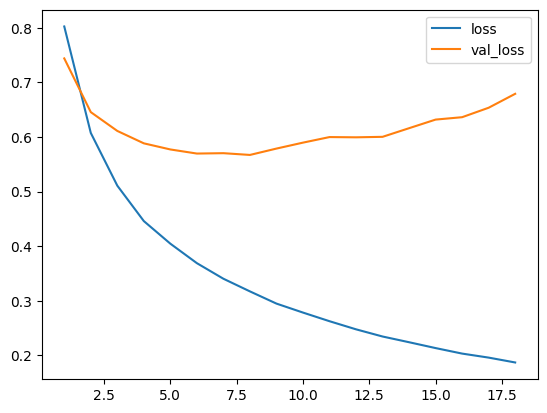

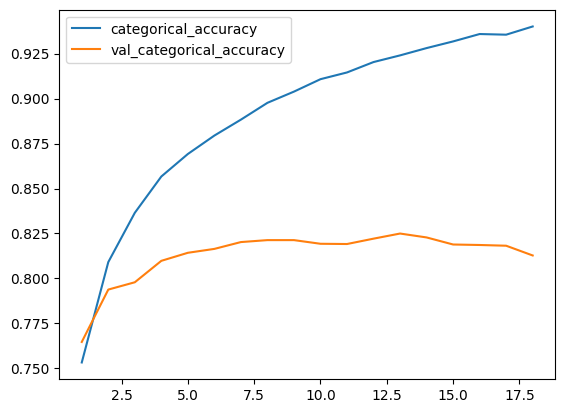

In [ ]:
# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()))

In [ ]:
# Decoding predições e labels de test por hard voting 
argy_test = [np.argmax(i) for i in y_test]
argy_pred = [np.argmax(i) for i in model.predict(X_test)]

455/455 [==============================] - 0s 963us/step


In [ ]:
# Resultado nos dados de test

print(f'MobileNet score on test set: {accuracy_score(argy_test, argy_pred)}')

MobileNet score on test set: 0.8268344680558422


### Testando com DenseNet169

In [ ]:
import tensorflow.keras.applications as apps
from tensorflow import keras
from tensorflow.keras import layers

model = apps.DenseNet169(include_top=False, weights='imagenet', input_shape=(64, 64, 3)) 
model = Model(inputs=model.input, outputs=model.get_layer(index=-1).output)
model.trainable = False

In [ ]:
print("Model output", model.output.shape)

Model output (None, 2, 2, 1664)


In [ ]:
preds = model.predict(X_data[0:5])

1/1 [==============================] - 2s 2s/step


In [ ]:
print("prediction shape", np.array(preds[0]).shape)

prediction shape (2, 2, 1664)


In [ ]:
Predshape = np.array(preds[0]).reshape(-1).shape[0]
print(f"predshape: {Predshape}")

predshape: 6656


In [ ]:
# Extração de features
print("Feature extraction ...")
prediction = np.array(model.predict(X_data))
featuresData = np.reshape(prediction, (prediction.shape[0], Predshape))

print('\tFeatures data shape: ', featuresData.shape)

Feature extraction ...
1377/1377 [==============================] - 165s 120ms/step
	Features data shape:  (44062, 6656)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(featuresData)

print('X_reduced shape: ', X_reduced.shape)

X_reduced shape:  (44062, 68)


In [ ]:
from sklearn.preprocessing import label_binarize
labels = [i for i in range(0, 21)]

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_data, test_size=0.33)

y_train = np.array(label_binarize(y_train, classes=labels))
y_test = np.array(label_binarize(y_test, classes=labels))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [ ]:
print(f'training set shape {X_train.shape}')
print(f'testing set shape {X_test.shape}')
print(f'label train set shape {y_train.shape}')
print(f'label test set shape {y_test.shape}')

training set shape (22140, 68)
testing set shape (14541, 68)
label train set shape (22140, 21)
label test set shape (14541, 21)


In [ ]:
# Creating the Sequential Model
model = keras.Sequential([
    
    # Fully-connected layer
    layers.Dense(42, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(21, activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 42)                2898      
                                                                 
 dense_10 (Dense)            (None, 21)                903       
                                                                 
Total params: 3,801
Trainable params: 3,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
692/692 [==============================] - 1s 2ms/step - loss: 6.8258 - categorical_accuracy: 0.6546 - val_loss: 0.9017 - val_categorical_accuracy: 0.8622
Epoch 2/100
692/692 [==============================] - 1s 2ms/step - loss: 0.5143 - categorical_accuracy: 0.9025 - val_loss: 0.3682 - val_categorical_accuracy: 0.9228
Epoch 3/100
692/692 [==============================] - 1s 2ms/step - loss: 0.2302 - categorical_accuracy: 0.9432 - val_loss: 0.2318 - val_categorical_accuracy: 0.9430
Epoch 4/100
692/692 [==============================] - 1s 2ms/step - loss: 0.1336 - categorical_accuracy: 0.9623 - val_loss: 0.1395 - val_categorical_accuracy: 0.9621
Epoch 5/100
692/692 [==============================] - 1s 1ms/step - loss: 0.0900 - categorical_accuracy: 0.9737 - val_loss: 0.1454 - val_categorical_accuracy: 0.9640
Epoch 6/100
692/692 [==============================] - 1s 1ms/step - loss: 0.0752 - categorical_accuracy: 0.9774 - val_loss: 0.1342 - val_categorical_accuracy: 0.964

Best Validation Loss: 0.0615
Best Validation Accuracy: 0.9847


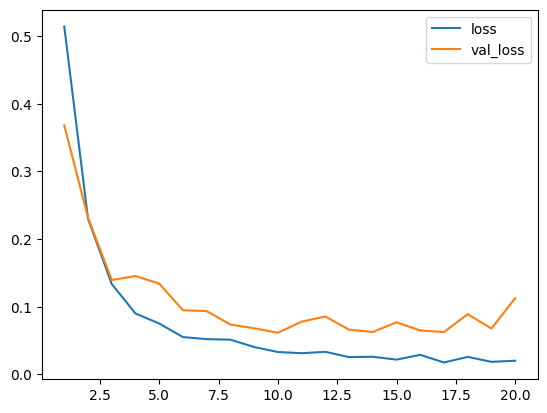

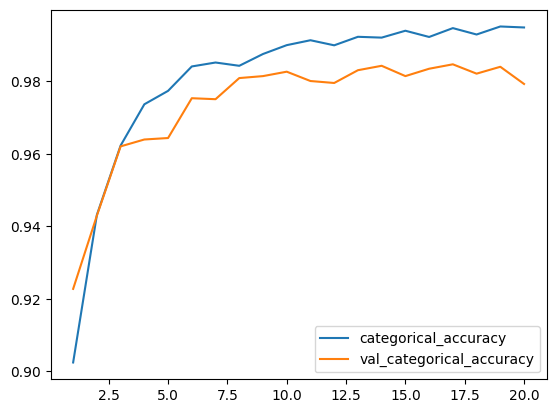

In [ ]:
# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()))

In [ ]:
# Decoding predições e labels de test por hard voting 
argy_test = [np.argmax(i) for i in y_test]
argy_pred = [np.argmax(i) for i in model.predict(X_test)]

455/455 [==============================] - 0s 774us/step


In [ ]:
# Resultado nos dados de test

print(f'DenseNet169 score on test set: {accuracy_score(argy_test, argy_pred)}')

DenseNet169 score on test set: 0.9845265112440685


## Resultados:
### VGG: val_loss = 0.0153, val_categorical_accuracy = 99.88%, test_score = 99.68%
### ResNetV2: val_loss = 0.0012, val_categorical_accuracy = 99.97%, test_score = 99.94% 
### EfficientNetB3: val_loss = 0.0004, val_categorical_accuracy = 99.99%, test_score = 99.96%
### MobileNet: val_loss = 0.5670, val_categoricla_accuracy = 82.50%, test_score = 82.68%
### DenseNet169: val_loss = 0.0615, val_categorical_accuracy = 98,47%, test_score = 98,45%